**1. Introduction**

This project aims to predict levels of Depression, Anxiety, and Stress using machine learning techniques. By analyzing psychological questionnaire data, we apply classification models to identify mental health categories for each respondent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp /content/data.csv /content/drive/MyDrive/


cp: cannot stat '/content/data.csv': No such file or directory


In [4]:
!mv /content/data.csv /content/drive/MyDrive/

mv: cannot stat '/content/data.csv': No such file or directory


**2. Data Loading & Preprocessing**

We load the dataset, clean invalid responses (e.g., through attention-check questions like VCL6, VCL9, VCL12), and retain only reliable entries. Categorical features are encoded, and necessary columns are dropped to prepare for model training.

In [5]:
dataset_path = '/content/drive/MyDrive/data.csv'
encodings_to_try = ['utf-8', 'utf-8-sig', 'latin-1', 'ISO-8859-1', 'cp1252', 'utf-16']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv(dataset_path, sep='\t')

        break
    except UnicodeDecodeError:
        pass
df.tail()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize,major
39770,2,31,3287,1,5,2216,3,29,3895,2,...,2,1,1,2,4,60,2,1,2,NaN
39771,3,14,4792,4,41,2604,3,15,2668,4,...,1,1,1,10,0,10,2,1,4,Mathematic
39772,2,1,25147,1,4,4555,2,14,3388,1,...,2,1,1,7,1,30,1,2,3,Computer Science
39773,3,36,4286,1,34,2736,2,10,5968,2,...,2,1,1,6,1,60,1,1,2,History
39774,2,28,32251,1,22,3317,2,4,11734,1,...,1,1,1,10,1,10,1,1,4,Cognitive Science


In [6]:

print(df.dtypes)

Q1A            int64
Q1I            int64
Q1E            int64
Q2A            int64
Q2I            int64
               ...  
race           int64
voted          int64
married        int64
familysize     int64
major         object
Length: 172, dtype: object


In [7]:
df['wrongansw'] = 0
df['wrongansw'] = df['wrongansw'].where(df['VCL6']== 0, df['wrongansw'] + 1)
df['wrongansw'] = df['wrongansw'].where(df['VCL9']== 0, df['wrongansw'] + 1)
df['wrongansw'] = df['wrongansw'].where(df['VCL12']== 0, df['wrongansw'] + 1)

df.wrongansw.value_counts()

,count
wrongansw,
0,34583
1,4044
2,822
3,326


In [8]:
df = df[df['wrongansw'].isin([2, 3])]
df = df.drop(columns='wrongansw')
df.head(3)
df.shape

(1148, 172)

In [9]:
# removing the validity check columns
vcls = []
for i in range(1, 17):
    vcls.append('VCL' + str(i))

df = df.drop(columns=vcls)
df.shape

(1148, 156)

In [10]:
print(df.columns.tolist())


['Q1A', 'Q1I', 'Q1E', 'Q2A', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E', 'Q4A', 'Q4I', 'Q4E', 'Q5A', 'Q5I', 'Q5E', 'Q6A', 'Q6I', 'Q6E', 'Q7A', 'Q7I', 'Q7E', 'Q8A', 'Q8I', 'Q8E', 'Q9A', 'Q9I', 'Q9E', 'Q10A', 'Q10I', 'Q10E', 'Q11A', 'Q11I', 'Q11E', 'Q12A', 'Q12I', 'Q12E', 'Q13A', 'Q13I', 'Q13E', 'Q14A', 'Q14I', 'Q14E', 'Q15A', 'Q15I', 'Q15E', 'Q16A', 'Q16I', 'Q16E', 'Q17A', 'Q17I', 'Q17E', 'Q18A', 'Q18I', 'Q18E', 'Q19A', 'Q19I', 'Q19E', 'Q20A', 'Q20I', 'Q20E', 'Q21A', 'Q21I', 'Q21E', 'Q22A', 'Q22I', 'Q22E', 'Q23A', 'Q23I', 'Q23E', 'Q24A', 'Q24I', 'Q24E', 'Q25A', 'Q25I', 'Q25E', 'Q26A', 'Q26I', 'Q26E', 'Q27A', 'Q27I', 'Q27E', 'Q28A', 'Q28I', 'Q28E', 'Q29A', 'Q29I', 'Q29E', 'Q30A', 'Q30I', 'Q30E', 'Q31A', 'Q31I', 'Q31E', 'Q32A', 'Q32I', 'Q32E', 'Q33A', 'Q33I', 'Q33E', 'Q34A', 'Q34I', 'Q34E', 'Q35A', 'Q35I', 'Q35E', 'Q36A', 'Q36I', 'Q36E', 'Q37A', 'Q37I', 'Q37E', 'Q38A', 'Q38I', 'Q38E', 'Q39A', 'Q39I', 'Q39E', 'Q40A', 'Q40I', 'Q40E', 'Q41A', 'Q41I', 'Q41E', 'Q42A', 'Q42I', 'Q42E', 'country', 'source

In [11]:
categorical = df.select_dtypes('object').columns

print('Categorical Columns: ', df[categorical].columns)
print(df[categorical].nunique())

# remove 'major' column
df = df.drop(['major'], axis=1)

Categorical Columns:  Index(['country', 'major'], dtype='object')
country     68
major      365
dtype: int64


In [12]:

df

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,age,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize
26,4,1,4820,4,39,1109,4,8,1833,4,...,15,1,1,1,7,1,60,2,1,3
31,2,25,3671,2,26,5743,2,13,3154,1,...,18,1,1,1,2,1,60,2,1,3
57,2,27,3827,3,33,6293,2,22,12153,3,...,21,2,1,1,1,1,60,1,1,2
81,4,14,2205,1,25,3320,2,40,2803,1,...,14,2,1,1,4,1,70,2,1,6
87,3,4,8405,2,29,5819,4,32,1925,4,...,17,1,1,1,1,1,30,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39621,3,10,3293,1,16,2830,3,12,3594,3,...,17,1,1,1,12,5,70,1,1,5
39643,2,18,3731,1,10,1623,3,13,2876,1,...,23,1,2,1,10,1,10,1,1,3
39644,1,25,412,1,2,11824,1,29,349,1,...,19,2,1,1,7,0,30,1,0,7
39734,4,37,3099,2,21,4454,4,1,11688,1,...,56,2,1,1,4,4,60,1,3,3


In [13]:
DASS_keys = {
    'Depression': [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42],
    'Anxiety': [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41],
    'Stress': [1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39]
    }

In [14]:

df.columns

Index(['Q1A', 'Q1I', 'Q1E', 'Q2A', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E', 'Q4A',
       ...
       'age', 'screensize', 'uniquenetworklocation', 'hand', 'religion',
       'orientation', 'race', 'voted', 'married', 'familysize'],
      dtype='object', length=155)

In [15]:
df.columns = df.columns.str.replace(' ','')
df.columns

Index(['Q1A', 'Q1I', 'Q1E', 'Q2A', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E', 'Q4A',
       ...
       'age', 'screensize', 'uniquenetworklocation', 'hand', 'religion',
       'orientation', 'race', 'voted', 'married', 'familysize'],
      dtype='object', length=155)

In [16]:
depr = []
for i in DASS_keys["Depression"]:
    depr.append('Q' + str(i) + 'A')

anx = []
for i in DASS_keys["Anxiety"]:
    anx.append('Q' + str(i) + 'A')

stre = []
for i in DASS_keys["Stress"]:
    stre.append('Q' + str(i) + 'A')

# making a new dataframe for each disorder

df_depr=df.filter(depr)
df_anx=df.filter(anx)
df_stre=df.filter(stre)

In [17]:

disorders = [depr, anx, stre]

def scores(df): # adds new columns to store total scores for each
    df["ScoresDepr"] = df[depr].sum(axis=1)
    df["ScoresAnx"] = df[anx].sum(axis=1)
    df["ScoresStre"] = df[stre].sum(axis=1)
    return df

for i in disorders:
        df[i] -= 1 # to get the scores

df = scores(df)

df.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,hand,religion,orientation,race,voted,married,familysize,ScoresDepr,ScoresAnx,ScoresStre
26,3,1,4820,3,39,1109,3,8,1833,3,...,1,7,1,60,2,1,3,38,41,41
31,1,25,3671,1,26,5743,1,13,3154,0,...,1,2,1,60,2,1,3,30,8,7
57,1,27,3827,2,33,6293,1,22,12153,2,...,1,1,1,60,1,1,2,13,15,20
81,3,14,2205,0,25,3320,1,40,2803,0,...,1,4,1,70,2,1,6,20,10,31
87,2,4,8405,1,29,5819,3,32,1925,3,...,1,1,1,30,2,1,3,42,36,39


**3. Feature Selection and Label Extraction**

We extract feature variables (e.g., questionnaire responses, demographics) and target variables (`CategoryDepr`, `CategoryAnx`, `CategoryStre`) to train models for each mental health category separately.

In [18]:
# CATEGORY: DEPRESSION
CategoryDepr=[]

for i in df['ScoresDepr']:
    if i in range(0,10):
        CategoryDepr.append('Normal')
    elif i in range(10,14):
        CategoryDepr.append('Minimal')
    elif i in range(14,21):
        CategoryDepr.append('Moderate')
    elif i in range(21,28):
        CategoryDepr.append('Severe')
    else:
        CategoryDepr.append('Extremely Severe')

df['CategoryDepr']= CategoryDepr

In [19]:
# CATEGORY: ANXIETY
CategoryAnx=[]

for i in df['ScoresAnx']:
    if i in range(0,8):
        CategoryAnx.append('Normal')
    elif i in range(8,10):
        CategoryAnx.append('Minimal')
    elif i in range(10,15):
        CategoryAnx.append('Moderate')
    elif i in range(15,20):
        CategoryAnx.append('Severe')
    else:
        CategoryAnx.append('Extremely Severe')

df['CategoryAnx']= CategoryAnx

In [20]:
# CATEGORY: STRESS
CategoryStre=[]

for i in df['ScoresStre']:
    if i in range(0,15):
        CategoryStre.append('Normal')
    elif i in range(15,19):
        CategoryStre.append('Minimal')
    elif i in range(19,26):
        CategoryStre.append('Moderate')
    elif i in range(26,34):
        CategoryStre.append('Severe')
    else:
        CategoryStre.append('Extremely Severe')

df['CategoryStre']= CategoryStre


In [21]:
# checking for duplicates
df.isnull().sum()
df.duplicated().sum()


np.int64(0)

In [22]:

df

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,race,voted,married,familysize,ScoresDepr,ScoresAnx,ScoresStre,CategoryDepr,CategoryAnx,CategoryStre
26,3,1,4820,3,39,1109,3,8,1833,3,...,60,2,1,3,38,41,41,Extremely Severe,Extremely Severe,Extremely Severe
31,1,25,3671,1,26,5743,1,13,3154,0,...,60,2,1,3,30,8,7,Extremely Severe,Minimal,Normal
57,1,27,3827,2,33,6293,1,22,12153,2,...,60,1,1,2,13,15,20,Minimal,Severe,Moderate
81,3,14,2205,0,25,3320,1,40,2803,0,...,70,2,1,6,20,10,31,Moderate,Moderate,Severe
87,2,4,8405,1,29,5819,3,32,1925,3,...,30,2,1,3,42,36,39,Extremely Severe,Extremely Severe,Extremely Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39621,2,10,3293,0,16,2830,2,12,3594,2,...,70,1,1,5,21,11,10,Severe,Moderate,Normal
39643,1,18,3731,0,10,1623,2,13,2876,0,...,10,1,1,3,23,7,11,Severe,Normal,Normal
39644,0,25,412,0,2,11824,0,29,349,0,...,30,1,0,7,0,1,3,Normal,Normal,Normal
39734,3,37,3099,1,21,4454,3,1,11688,0,...,60,1,3,3,42,26,41,Extremely Severe,Extremely Severe,Extremely Severe


In [23]:
Y = df['CategoryDepr']
X = df.drop(columns=['Q2A','Q4A','Q7A','Q9A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A','introelapse','testelapse', 'surveyelapse','engnat','CategoryAnx', 'CategoryDepr', 'CategoryStre','country', 'ScoresAnx' ,'ScoresStre','screensize','uniquenetworklocation','Q1A' ,'Q1I', 'Q1E', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E','Q4I','Q4E', 'Q5E', 'Q5A' ,'Q5I', 'Q6E', 'Q6A' ,'Q6I', 'Q7E' ,'Q7I', 'Q8E','Q8A' ,'Q8I', 'Q9E', 'Q9I', 'Q10E', 'Q10A', 'Q10I', 'Q11E', 'Q11A' ,'Q11I', 'Q12E', 'Q12A' ,'Q12I', 'Q13E', 'Q13A' ,'Q13I', 'Q14E', 'Q14A' ,'Q14I', 'Q15E', 'Q15I', 'Q16E', 'Q16A' ,'Q16I', 'Q17E', 'Q17A' ,'Q17I', 'Q18E', 'Q18A' ,'Q18I', 'Q19I', 'Q19E',  'Q20I', 'Q20E', 'Q21A', 'Q21I', 'Q21E', 'Q22A', 'Q22I','Q22E', 'Q23I','Q23E','Q24A','Q24I','Q24E', 'Q25I', 'Q25E', 'Q26A', 'Q26I', 'Q26E', 'Q27A', 'Q27I', 'Q27E', 'Q28I', 'Q28E', 'Q29A', 'Q29I', 'Q29E',  'Q30I', 'Q30E', 'Q31A', 'Q31I', 'Q31E', 'Q32A', 'Q32I', 'Q32E', 'Q33A', 'Q33I', 'Q33E', 'Q34A', 'Q34I', 'Q34E', 'Q35A', 'Q35I', 'Q35E', 'Q36I', 'Q36E', 'Q37A', 'Q37I', 'Q37E', 'Q38A', 'Q38I', 'Q38E', 'Q39A', 'Q39I', 'Q39E', 'Q40I', 'Q40E', 'Q41I', 'Q41E', 'Q42A', 'Q42I', 'Q42E'])
X.head()


,source,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,...,gender,age,hand,religion,orientation,race,voted,married,familysize,ScoresDepr
26,2,4,1,7,7,7,2,6,5,1,...,2,15,1,7,1,60,2,1,3,38
31,2,5,5,5,5,7,7,7,5,5,...,1,18,1,2,1,60,2,1,3,30
57,0,2,4,1,5,6,4,3,6,6,...,2,21,1,1,1,60,1,1,2,13
81,2,7,6,3,6,4,1,7,5,3,...,2,14,1,4,1,70,2,1,6,20
87,2,1,3,5,6,6,7,2,7,1,...,1,17,1,1,1,30,2,1,3,42


**4. Model Building & Training**

Multiple machine learning models are trained:
- K-Nearest Neighbors (KNN)
- Naive Bayes (NB)
- Support Vector Machine (SVM)
- Random Forest (RF)
- XGBoost (XGB)

Each model is evaluated using cross-validation for robust accuracy estimation.

In [24]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=85)


In [25]:
# KNN Model for Depression Classification

# Create a KNN classifier with k (number of neighbors)
knn = KNeighborsClassifier(n_neighbors=95)

# Fit the model to the training data
knn.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = knn.predict(X_test)

# Calculate the accuracy score of the model
accuracy_knn = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of KNN Model - Depression: {:.5f}'.format(accuracy_knn))
print('Confusion Matrix of KNN Model - Depression: \n', conf_matrix)
print('Confusion Matrix of KNN Model - Depression: \n', classif_report)

Accuracy of KNN Model - Depression: 0.59930
Confusion Matrix of KNN Model - Depression: 
 [[108   0   0   7   1]
 [  2   0   1  13   0]
 [ 29   0   2   7   0]
 [  9   0   5  62   0]
 [ 36   0   1   4   0]]
Confusion Matrix of KNN Model - Depression: 
                   precision    recall  f1-score   support

Extremely Severe       0.59      0.93      0.72       116
         Minimal       0.00      0.00      0.00        16
        Moderate       0.22      0.05      0.09        38
          Normal       0.67      0.82      0.73        76
          Severe       0.00      0.00      0.00        41

        accuracy                           0.60       287
       macro avg       0.30      0.36      0.31       287
    weighted avg       0.44      0.60      0.50       287



In [26]:
# SVC Model for Depression Classification
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, Y_train)

preds = svm_model.predict(X_test)

# Calculate the accuracy score of the model
accuracy_svc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of SVM Model - Depression: {:.5f}'.format(accuracy_svc))
print('Confusion Matrix of SVM Model - Depression: \n', conf_matrix)
print('Confusion Matrix of SVM Model - Depression: \n', classif_report)


Accuracy of SVM Model - Depression: 0.59930
Confusion Matrix of SVM Model - Depression: 
 [[108   0   0   7   1]
 [  2   0   1  13   0]
 [ 29   0   2   7   0]
 [  9   0   5  62   0]
 [ 36   0   1   4   0]]
Confusion Matrix of SVM Model - Depression: 
                   precision    recall  f1-score   support

Extremely Severe       0.59      0.93      0.72       116
         Minimal       0.00      0.00      0.00        16
        Moderate       0.22      0.05      0.09        38
          Normal       0.67      0.82      0.73        76
          Severe       0.00      0.00      0.00        41

        accuracy                           0.60       287
       macro avg       0.30      0.36      0.31       287
    weighted avg       0.44      0.60      0.50       287



In [27]:
# Naive Bayes Model for Depression Classification

clfNB = GaussianNB()

# Fit the model to the training data
clfNB.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfNB.predict(X_test)

# Calculate the accuracy score of the model
accuracy_nb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of NB Model - Depression: {:.5f}'.format(accuracy_nb))
print('Confusion Matrix of NB Model - Depression: \n', conf_matrix)
print('Classification Report of NB Model - Depression: \n', classif_report)


Accuracy of NB Model - Depression: 0.94425
Confusion Matrix of NB Model - Depression: 
 [[113   0   0   0   3]
 [  0  12   1   3   0]
 [  0   0  37   0   1]
 [  0   5   0  71   0]
 [  2   0   1   0  38]]
Classification Report of NB Model - Depression: 
                   precision    recall  f1-score   support

Extremely Severe       0.98      0.97      0.98       116
         Minimal       0.71      0.75      0.73        16
        Moderate       0.95      0.97      0.96        38
          Normal       0.96      0.93      0.95        76
          Severe       0.90      0.93      0.92        41

        accuracy                           0.94       287
       macro avg       0.90      0.91      0.91       287
    weighted avg       0.95      0.94      0.94       287



In [28]:
# Random Forest Classifier Model for Depression Classification

clfRFC = RandomForestClassifier(n_estimators=110, random_state=110)

# Fit the model to the training data
clfRFC.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfRFC.predict(X_test)

# Calculate the accuracy score of the model
accuracy_rfc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)


print('Accuracy of RFC Model - Depression: {:.5f}'.format(accuracy_rfc))
print('Confusion Matrix of RFC Model - Depression: \n', conf_matrix)
print('Classification report of RFC Model - Depression: \n', classif_report)

Accuracy of RFC Model - Depression: 0.97561
Confusion Matrix of RFC Model - Depression: 
 [[116   0   0   0   0]
 [  0  12   3   1   0]
 [  0   1  37   0   0]
 [  0   0   2  74   0]
 [  0   0   0   0  41]]
Classification report of RFC Model - Depression: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00       116
         Minimal       0.92      0.75      0.83        16
        Moderate       0.88      0.97      0.93        38
          Normal       0.99      0.97      0.98        76
          Severe       1.00      1.00      1.00        41

        accuracy                           0.98       287
       macro avg       0.96      0.94      0.95       287
    weighted avg       0.98      0.98      0.98       287



In [29]:
# XG Boost Classifier For Depression Classifier
xgb_model = XGBClassifier()
le = LabelEncoder()

xgb_model.fit(X_train, le.fit_transform(Y_train))

Y_pred = xgb_model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

accuracy_xgb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of XGB Model - Depression: {:.5f}'.format(accuracy_xgb))
print('Confusion Matrix of XGB Model - Depression: \n', conf_matrix)
print('Classification report of XGB Model - Depression: \n', classif_report)

Accuracy of XGB Model - Depression: 1.00000
Confusion Matrix of XGB Model - Depression: 
 [[116   0   0   0   0]
 [  0  16   0   0   0]
 [  0   0  38   0   0]
 [  0   0   0  76   0]
 [  0   0   0   0  41]]
Classification report of XGB Model - Depression: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00       116
         Minimal       1.00      1.00      1.00        16
        Moderate       1.00      1.00      1.00        38
          Normal       1.00      1.00      1.00        76
          Severe       1.00      1.00      1.00        41

        accuracy                           1.00       287
       macro avg       1.00      1.00      1.00       287
    weighted avg       1.00      1.00      1.00       287



In [30]:
import scipy

print("SciPy version:", scipy.__version__)


SciPy version: 1.16.0


In [31]:
!pip install --upgrade scipy numpy


  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.1 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.
plotnine 0.14.6 requires scipy<1.16.0,>=1.8.0, but you have scipy 1.16.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.


In [32]:
# Combining Naive Bayes, XG Boost and Random Forest

# Training the models on whole data
final_xgb_model = XGBClassifier()
final_nb_model = GaussianNB()
final_rfc_model = RandomForestClassifier(n_estimators=110, random_state=110)


final_xgb_model.fit(X_train, le.fit_transform(Y_train))
final_nb_model.fit(X_train, Y_train)
final_rfc_model.fit(X_train, Y_train)

# Making prediction by take mode of predictions made by all the classifiers
xgb_preds = final_xgb_model.predict(X_test)
xgb_preds = le.inverse_transform(xgb_preds)

nb_preds = final_nb_model.predict(X_test)
rfc_preds = final_rfc_model.predict(X_test)

final_preds = [np.vstack([i,j,k])[0][0] for i,j, k in zip(xgb_preds, nb_preds, rfc_preds)]

accuracy_combined = accuracy_score(Y_test, final_preds)
conf_matrix = confusion_matrix(Y_test, final_preds)
classif_report = classification_report(Y_test, final_preds)

print('Accuracy of Combined Model - Depression: {:.5f}'.format(accuracy_combined))
print('Confusion Matrix of Combined Model - Depression: \n', conf_matrix)
print('Classification report of Combined Model - Depression: \n', classif_report)


Accuracy of Combined Model - Depression: 1.00000
Confusion Matrix of Combined Model - Depression: 
 [[116   0   0   0   0]
 [  0  16   0   0   0]
 [  0   0  38   0   0]
 [  0   0   0  76   0]
 [  0   0   0   0  41]]
Classification report of Combined Model - Depression: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00       116
         Minimal       1.00      1.00      1.00        16
        Moderate       1.00      1.00      1.00        38
          Normal       1.00      1.00      1.00        76
          Severe       1.00      1.00      1.00        41

        accuracy                           1.00       287
       macro avg       1.00      1.00      1.00       287
    weighted avg       1.00      1.00      1.00       287



In [33]:
accuracy_depression = [accuracy_knn, accuracy_svc, accuracy_nb, accuracy_rfc, accuracy_xgb, accuracy_combined]

depression_analysis = pd.DataFrame({
                        'Models' : ['KNN', 'SVC', 'Naive Bayes', 'Random Forest', 'XG Boost', 'Combined Model'],
                        'Accuracy_Depression': [x * 100 for x in accuracy_depression]
                    })

In [34]:
Y = df['CategoryAnx']
X = df.drop(columns=['Q2A','Q4A','Q7A','Q9A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A','introelapse','testelapse', 'surveyelapse','engnat','CategoryAnx','CategoryDepr', 'CategoryStre','country', 'ScoresDepr' ,'ScoresStre','screensize','uniquenetworklocation','Q1A' ,'Q1I', 'Q1E', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E','Q4I','Q4E', 'Q5E', 'Q5A' ,'Q5I', 'Q6E', 'Q6A' ,'Q6I', 'Q7E' ,'Q7I', 'Q8E','Q8A' ,'Q8I', 'Q9E', 'Q9I', 'Q10E', 'Q10A', 'Q10I', 'Q11E', 'Q11A' ,'Q11I', 'Q12E', 'Q12A' ,'Q12I', 'Q13E', 'Q13A' ,'Q13I', 'Q14E', 'Q14A' ,'Q14I', 'Q15E', 'Q15I', 'Q16E', 'Q16A' ,'Q16I', 'Q17E', 'Q17A' ,'Q17I', 'Q18E', 'Q18A' ,'Q18I', 'Q19I', 'Q19E',  'Q20I', 'Q20E', 'Q21A', 'Q21I', 'Q21E', 'Q22A', 'Q22I','Q22E', 'Q23I','Q23E','Q24A','Q24I','Q24E', 'Q25I', 'Q25E', 'Q26A', 'Q26I', 'Q26E', 'Q27A', 'Q27I', 'Q27E', 'Q28I', 'Q28E', 'Q29A', 'Q29I', 'Q29E',  'Q30I', 'Q30E', 'Q31A', 'Q31I', 'Q31E', 'Q32A', 'Q32I', 'Q32E', 'Q33A', 'Q33I', 'Q33E', 'Q34A', 'Q34I', 'Q34E', 'Q35A', 'Q35I', 'Q35E', 'Q36I', 'Q36E', 'Q37A', 'Q37I', 'Q37E', 'Q38A', 'Q38I', 'Q38E', 'Q39A', 'Q39I', 'Q39E', 'Q40I', 'Q40E', 'Q41I', 'Q41E', 'Q42A', 'Q42I', 'Q42E'])
X.head()


,source,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,...,gender,age,hand,religion,orientation,race,voted,married,familysize,ScoresAnx
26,2,4,1,7,7,7,2,6,5,1,...,2,15,1,7,1,60,2,1,3,41
31,2,5,5,5,5,7,7,7,5,5,...,1,18,1,2,1,60,2,1,3,8
57,0,2,4,1,5,6,4,3,6,6,...,2,21,1,1,1,60,1,1,2,15
81,2,7,6,3,6,4,1,7,5,3,...,2,14,1,4,1,70,2,1,6,10
87,2,1,3,5,6,6,7,2,7,1,...,1,17,1,1,1,30,2,1,3,36


In [35]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=85)


In [36]:
# KNN Classification
# Create a KNN classifier with k (number of neighbors)
knn = KNeighborsClassifier(n_neighbors=95)

# Fit the model to the training data
knn.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = knn.predict(X_test)

# Calculate the accuracy score of the model
accuracy_knn = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of KNN Model - Anxiety: {:.5f}'.format(accuracy_knn))
print('Confusion Matrix of KNN Model - Anxiety: \n', conf_matrix)
print('Confusion Matrix of KNN Model - Anxiety: \n', classif_report)


Accuracy of KNN Model - Anxiety: 0.63066
Confusion Matrix of KNN Model - Anxiety: 
 [[112   0   0   0   0]
 [  9   0   0  11   0]
 [ 24   0   0  10   0]
 [ 17   0   0  69   0]
 [ 35   0   0   0   0]]
Confusion Matrix of KNN Model - Anxiety: 
                   precision    recall  f1-score   support

Extremely Severe       0.57      1.00      0.72       112
         Minimal       0.00      0.00      0.00        20
        Moderate       0.00      0.00      0.00        34
          Normal       0.77      0.80      0.78        86
          Severe       0.00      0.00      0.00        35

        accuracy                           0.63       287
       macro avg       0.27      0.36      0.30       287
    weighted avg       0.45      0.63      0.52       287



In [37]:
# SVC Model for Anxiety Classification
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, Y_train)

preds = svm_model.predict(X_test)

# Calculate the accuracy score of the model
accuracy_svc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of SVM Model - Anxiety: {:.5f}'.format(accuracy_svc))
print('Confusion Matrix of SVM Model - Anxiety: \n', conf_matrix)
print('Confusion Matrix of SVM Model - Anxiety: \n', classif_report)


Accuracy of SVM Model - Anxiety: 0.63066
Confusion Matrix of SVM Model - Anxiety: 
 [[112   0   0   0   0]
 [  9   0   0  11   0]
 [ 24   0   0  10   0]
 [ 17   0   0  69   0]
 [ 35   0   0   0   0]]
Confusion Matrix of SVM Model - Anxiety: 
                   precision    recall  f1-score   support

Extremely Severe       0.57      1.00      0.72       112
         Minimal       0.00      0.00      0.00        20
        Moderate       0.00      0.00      0.00        34
          Normal       0.77      0.80      0.78        86
          Severe       0.00      0.00      0.00        35

        accuracy                           0.63       287
       macro avg       0.27      0.36      0.30       287
    weighted avg       0.45      0.63      0.52       287



In [38]:
# Naive Bayes Model for Anxiety Classification
clfNB = GaussianNB()

# Fit the model to the training data
clfNB.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfNB.predict(X_test)

# Calculate the accuracy score of the model
accuracy_nb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of NB Model - Anxiety: {:.5f}'.format(accuracy_nb))
print('Confusion Matrix of NB Model - Anxiety: \n', conf_matrix)
print('Classification Report of NB Model - Anxiety: \n', classif_report)

Accuracy of NB Model - Anxiety: 0.97213
Confusion Matrix of NB Model - Anxiety: 
 [[110   0   0   0   2]
 [  1  19   0   0   0]
 [  0   0  32   0   2]
 [  1   0   0  85   0]
 [  2   0   0   0  33]]
Classification Report of NB Model - Anxiety: 
                   precision    recall  f1-score   support

Extremely Severe       0.96      0.98      0.97       112
         Minimal       1.00      0.95      0.97        20
        Moderate       1.00      0.94      0.97        34
          Normal       1.00      0.99      0.99        86
          Severe       0.89      0.94      0.92        35

        accuracy                           0.97       287
       macro avg       0.97      0.96      0.97       287
    weighted avg       0.97      0.97      0.97       287



In [39]:
# Random Forest Classifier Model for Anxiety Classification
clfRFC = RandomForestClassifier(n_estimators=95, random_state=85)

# Fit the model to the training data
clfRFC.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfRFC.predict(X_test)

# Calculate the accuracy score of the model
accuracy_rfc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)


print('Accuracy of RFC Model - Anxiety: {:.5f}'.format(accuracy_rfc))
print('Confusion Matrix of RFC Model - Anxiety: \n', conf_matrix)
print('Classification report of KNN Model - Anxiety: \n', classif_report)

Accuracy of RFC Model - Anxiety: 0.94077
Confusion Matrix of RFC Model - Anxiety: 
 [[112   0   0   0   0]
 [  0   3  15   2   0]
 [  0   0  34   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  35]]
Classification report of KNN Model - Anxiety: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00       112
         Minimal       1.00      0.15      0.26        20
        Moderate       0.69      1.00      0.82        34
          Normal       0.98      1.00      0.99        86
          Severe       1.00      1.00      1.00        35

        accuracy                           0.94       287
       macro avg       0.93      0.83      0.81       287
    weighted avg       0.96      0.94      0.92       287



In [40]:
# XG Boost Classifier For Anxiety Classifier
xgb_model = XGBClassifier()
le = LabelEncoder()

xgb_model.fit(X_train, le.fit_transform(Y_train))

Y_pred = xgb_model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

accuracy_xgb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of XGB Model - Anxiety: {:.5f}'.format(accuracy_xgb))
print('Confusion Matrix of XGB Model - Anxiety: \n', conf_matrix)
print('Classification report of XGB Model - Anxiety: \n', classif_report)

Accuracy of XGB Model - Anxiety: 1.00000
Confusion Matrix of XGB Model - Anxiety: 
 [[112   0   0   0   0]
 [  0  20   0   0   0]
 [  0   0  34   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  35]]
Classification report of XGB Model - Anxiety: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00       112
         Minimal       1.00      1.00      1.00        20
        Moderate       1.00      1.00      1.00        34
          Normal       1.00      1.00      1.00        86
          Severe       1.00      1.00      1.00        35

        accuracy                           1.00       287
       macro avg       1.00      1.00      1.00       287
    weighted avg       1.00      1.00      1.00       287



In [41]:
# Combining Naive Bayes, XG Boost and Random Forest

# Training the models on whole data
final_xgb_model = XGBClassifier()
final_nb_model = GaussianNB()
final_rfc_model = RandomForestClassifier(n_estimators=110, random_state=110)


final_xgb_model.fit(X_train, le.fit_transform(Y_train))
final_nb_model.fit(X_train, Y_train)
final_rfc_model.fit(X_train, Y_train)

# Making prediction by take mode of predictions made by all the classifiers
xgb_preds = final_xgb_model.predict(X_test)
xgb_preds = le.inverse_transform(xgb_preds)

nb_preds = final_nb_model.predict(X_test)
rfc_preds = final_rfc_model.predict(X_test)

final_preds = [np.vstack([i,j,k])[0][0] for i,j, k in zip(xgb_preds, nb_preds, rfc_preds)]

accuracy_combined = accuracy_score(Y_test, final_preds)
conf_matrix = confusion_matrix(Y_test, final_preds)
classif_report = classification_report(Y_test, final_preds)

print('Accuracy of Combined Model - Anxiety: {:.5f}'.format(accuracy_combined))
print('Confusion Matrix of Combined Model - Anxiety: \n', conf_matrix)
print('Classification report of Combined Model - Anxiety: \n', classif_report)

Accuracy of Combined Model - Anxiety: 1.00000
Confusion Matrix of Combined Model - Anxiety: 
 [[112   0   0   0   0]
 [  0  20   0   0   0]
 [  0   0  34   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  35]]
Classification report of Combined Model - Anxiety: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00       112
         Minimal       1.00      1.00      1.00        20
        Moderate       1.00      1.00      1.00        34
          Normal       1.00      1.00      1.00        86
          Severe       1.00      1.00      1.00        35

        accuracy                           1.00       287
       macro avg       1.00      1.00      1.00       287
    weighted avg       1.00      1.00      1.00       287



In [42]:
accuracy_anxiety = [accuracy_knn, accuracy_svc, accuracy_nb, accuracy_rfc, accuracy_xgb, accuracy_combined]

anxiety_analysis = pd.DataFrame({
                        'Models' : ['KNN', 'SVC', 'Naive Bayes', 'Random Forest', 'XG Boost', 'Combined Model'],
                        'Accuracy_Anxiety': [x * 100 for x in accuracy_anxiety]
                    })

In [43]:
Y = df['CategoryStre']
X = df.drop(columns=['Q2A','Q4A','Q7A','Q9A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A','introelapse','testelapse', 'surveyelapse','engnat','CategoryStre','CategoryAnx', 'CategoryDepr', 'country', 'ScoresDepr' ,'ScoresAnx','screensize','uniquenetworklocation','Q1A' ,'Q1I', 'Q1E', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E','Q4I','Q4E', 'Q5E', 'Q5A' ,'Q5I', 'Q6E', 'Q6A' ,'Q6I', 'Q7E' ,'Q7I', 'Q8E','Q8A' ,'Q8I', 'Q9E', 'Q9I', 'Q10E', 'Q10A', 'Q10I', 'Q11E', 'Q11A' ,'Q11I', 'Q12E', 'Q12A' ,'Q12I', 'Q13E', 'Q13A' ,'Q13I', 'Q14E', 'Q14A' ,'Q14I', 'Q15E', 'Q15I', 'Q16E', 'Q16A' ,'Q16I', 'Q17E', 'Q17A' ,'Q17I', 'Q18E', 'Q18A' ,'Q18I', 'Q19I', 'Q19E',  'Q20I', 'Q20E', 'Q21A', 'Q21I', 'Q21E', 'Q22A', 'Q22I','Q22E', 'Q23I','Q23E','Q24A','Q24I','Q24E', 'Q25I', 'Q25E', 'Q26A', 'Q26I', 'Q26E', 'Q27A', 'Q27I', 'Q27E', 'Q28I', 'Q28E', 'Q29A', 'Q29I', 'Q29E',  'Q30I', 'Q30E', 'Q31A', 'Q31I', 'Q31E', 'Q32A', 'Q32I', 'Q32E', 'Q33A', 'Q33I', 'Q33E', 'Q34A', 'Q34I', 'Q34E', 'Q35A', 'Q35I', 'Q35E', 'Q36I', 'Q36E', 'Q37A', 'Q37I', 'Q37E', 'Q38A', 'Q38I', 'Q38E', 'Q39A', 'Q39I', 'Q39E', 'Q40I', 'Q40E', 'Q41I', 'Q41E', 'Q42A', 'Q42I', 'Q42E'])
X.head()


,source,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,...,gender,age,hand,religion,orientation,race,voted,married,familysize,ScoresStre
26,2,4,1,7,7,7,2,6,5,1,...,2,15,1,7,1,60,2,1,3,41
31,2,5,5,5,5,7,7,7,5,5,...,1,18,1,2,1,60,2,1,3,7
57,0,2,4,1,5,6,4,3,6,6,...,2,21,1,1,1,60,1,1,2,20
81,2,7,6,3,6,4,1,7,5,3,...,2,14,1,4,1,70,2,1,6,31
87,2,1,3,5,6,6,7,2,7,1,...,1,17,1,1,1,30,2,1,3,39


In [44]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=85)

In [45]:
# KNN Model for Stress Classification

# Create a KNN classifier with k (number of neighbors)
knn = KNeighborsClassifier(n_neighbors=95)

# Fit the model to the training data
knn.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = knn.predict(X_test)

# Calculate the accuracy score of the model
accuracy_knn = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of KNN Model - Stress: {:.5f}'.format(accuracy_knn))
print('Confusion Matrix of KNN Model - Stress: \n', conf_matrix)
print('Confusion Matrix of KNN Model - Stress: \n', classif_report)

Accuracy of KNN Model - Stress: 0.49477
Confusion Matrix of KNN Model - Stress: 
 [[14  0  0  1 45]
 [ 0  0 10 13 12]
 [ 1  0 11 10 26]
 [ 0  0 11 72  3]
 [ 0  0  6  7 45]]
Confusion Matrix of KNN Model - Stress: 
                   precision    recall  f1-score   support

Extremely Severe       0.93      0.23      0.37        60
         Minimal       0.00      0.00      0.00        35
        Moderate       0.29      0.23      0.26        48
          Normal       0.70      0.84      0.76        86
          Severe       0.34      0.78      0.48        58

        accuracy                           0.49       287
       macro avg       0.45      0.42      0.37       287
    weighted avg       0.52      0.49      0.45       287



In [46]:
# SVC Model for Stress Classification
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, Y_train)

preds = svm_model.predict(X_test)

# Calculate the accuracy score of the model
accuracy_svc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of SVM Model - Anxiety: {:.5f}'.format(accuracy_svc))
print('Confusion Matrix of SVM Model - Anxiety: \n', conf_matrix)
print('Confusion Matrix of SVM Model - Anxiety: \n', classif_report)

Accuracy of SVM Model - Anxiety: 0.49477
Confusion Matrix of SVM Model - Anxiety: 
 [[14  0  0  1 45]
 [ 0  0 10 13 12]
 [ 1  0 11 10 26]
 [ 0  0 11 72  3]
 [ 0  0  6  7 45]]
Confusion Matrix of SVM Model - Anxiety: 
                   precision    recall  f1-score   support

Extremely Severe       0.93      0.23      0.37        60
         Minimal       0.00      0.00      0.00        35
        Moderate       0.29      0.23      0.26        48
          Normal       0.70      0.84      0.76        86
          Severe       0.34      0.78      0.48        58

        accuracy                           0.49       287
       macro avg       0.45      0.42      0.37       287
    weighted avg       0.52      0.49      0.45       287



In [47]:
# Naive Bayes Model for Stress Classification

clfNB = GaussianNB()

# Fit the model to the training data
clfNB.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfNB.predict(X_test)

# Calculate the accuracy score of the model
accuracy_nb = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)

print('Accuracy of NB Model - Stress: {:.5f}'.format(accuracy_nb))
print('Confusion Matrix of NB Model - Stress: \n', conf_matrix)
print('Classification Report of KNN Model - Stress: \n', classif_report)

Accuracy of NB Model - Stress: 0.93728
Confusion Matrix of NB Model - Stress: 
 [[59  0  0  0  1]
 [ 0 32  0  3  0]
 [ 1  1 43  1  2]
 [ 0  1  0 85  0]
 [ 3  0  5  0 50]]
Classification Report of KNN Model - Stress: 
                   precision    recall  f1-score   support

Extremely Severe       0.94      0.98      0.96        60
         Minimal       0.94      0.91      0.93        35
        Moderate       0.90      0.90      0.90        48
          Normal       0.96      0.99      0.97        86
          Severe       0.94      0.86      0.90        58

        accuracy                           0.94       287
       macro avg       0.93      0.93      0.93       287
    weighted avg       0.94      0.94      0.94       287



In [48]:
# Random Forest Classifier Model for Stress Classification

clfRFC = RandomForestClassifier(n_estimators=95, random_state=85)

# Fit the model to the training data
clfRFC.fit(X_train, Y_train)

# Predict the classes of the testing set
Y_pred = clfRFC.predict(X_test)

# Calculate the accuracy score of the model
accuracy_rfc = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
classif_report = classification_report(Y_test, Y_pred)
print('Accuracy of RFC Model - Stress: {:.5f}'.format(accuracy_rfc))
print('Confusion Matrix of RFC Model - Stress: \n', conf_matrix)
print('Classification report of KNN Model - Stress: \n', classif_report)

Accuracy of RFC Model - Stress: 0.96516
Confusion Matrix of RFC Model - Stress: 
 [[60  0  0  0  0]
 [ 0 25 10  0  0]
 [ 0  0 48  0  0]
 [ 0  0  0 86  0]
 [ 0  0  0  0 58]]
Classification report of KNN Model - Stress: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00        60
         Minimal       1.00      0.71      0.83        35
        Moderate       0.83      1.00      0.91        48
          Normal       1.00      1.00      1.00        86
          Severe       1.00      1.00      1.00        58

        accuracy                           0.97       287
       macro avg       0.97      0.94      0.95       287
    weighted avg       0.97      0.97      0.96       287



In [49]:
# Combining Naive Bayes, XG Boost and Random Forest

# Training the models on whole data
final_xgb_model = XGBClassifier()
final_nb_model = GaussianNB()
final_rfc_model = RandomForestClassifier(n_estimators=110, random_state=110)


final_xgb_model.fit(X_train, le.fit_transform(Y_train))
final_nb_model.fit(X_train, Y_train)
final_rfc_model.fit(X_train, Y_train)

# Making prediction by take mode of predictions made by all the classifiers
xgb_preds = final_xgb_model.predict(X_test)
xgb_preds = le.inverse_transform(xgb_preds)

nb_preds = final_nb_model.predict(X_test)
rfc_preds = final_rfc_model.predict(X_test)

final_preds = [np.vstack([i,j,k])[0][0] for i,j, k in zip(xgb_preds, nb_preds, rfc_preds)]

accuracy_combined = accuracy_score(Y_test, final_preds)
conf_matrix = confusion_matrix(Y_test, final_preds)
classif_report = classification_report(Y_test, final_preds)

print('Accuracy of Combined Model - Stress: {:.5f}'.format(accuracy_combined))
print('Confusion Matrix of Combined Model - Stress: \n', conf_matrix)
print('Classification report of Combined Model - Stress: \n', classif_report)

Accuracy of Combined Model - Stress: 1.00000
Confusion Matrix of Combined Model - Stress: 
 [[60  0  0  0  0]
 [ 0 35  0  0  0]
 [ 0  0 48  0  0]
 [ 0  0  0 86  0]
 [ 0  0  0  0 58]]
Classification report of Combined Model - Stress: 
                   precision    recall  f1-score   support

Extremely Severe       1.00      1.00      1.00        60
         Minimal       1.00      1.00      1.00        35
        Moderate       1.00      1.00      1.00        48
          Normal       1.00      1.00      1.00        86
          Severe       1.00      1.00      1.00        58

        accuracy                           1.00       287
       macro avg       1.00      1.00      1.00       287
    weighted avg       1.00      1.00      1.00       287



**5. Cross-Validation & Performance Evaluation**

We apply k-fold cross-validation (typically 5-fold) to evaluate each model’s performance. Mean accuracy scores are calculated to reduce variance from any single train/test split.

In [50]:
accuracy_stress = [accuracy_knn, accuracy_svc, accuracy_nb, accuracy_rfc, accuracy_xgb, accuracy_combined]

stress_analysis = pd.DataFrame({
                        'Models' : ['KNN', 'SVC', 'Naive Bayes', 'Random Forest', 'XG Boost', 'Combined Model'],
                        'Accuracy_Stress': [x * 100 for x in accuracy_stress]
                    })

In [51]:
analysis = pd.concat([stress_analysis.set_index('Models'),
                      anxiety_analysis.set_index('Models'),
                      depression_analysis.set_index('Models')],
                     axis=1)


In [52]:
analysis.head()

,Accuracy_Stress,Accuracy_Anxiety,Accuracy_Depression
Models,,,
KNN,49.477352,63.066202,59.930314
SVC,49.477352,63.066202,59.930314
Naive Bayes,93.728223,97.212544,94.425087
Random Forest,96.515679,94.076655,97.560976
XG Boost,100.000000,100.000000,100.000000


**Results & Comparison**

The models' performances are compared based on their average accuracies. This helps identify the best-suited algorithm for each label (stress, anxiety, or depression).

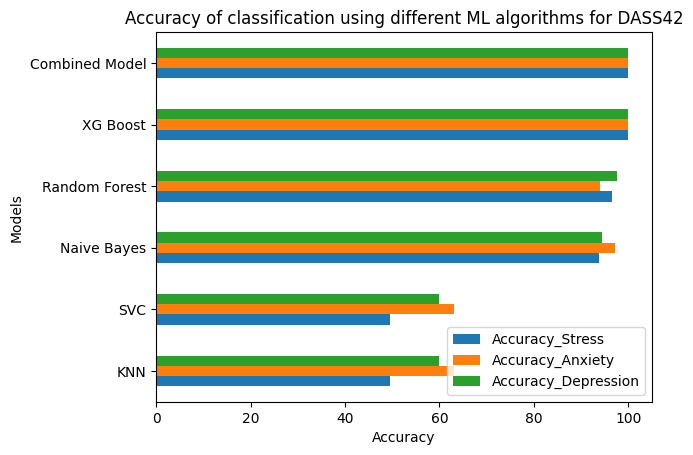

In [53]:
ax = analysis.plot(kind='barh')
plt.title("Accuracy of classification using different ML algorithms for DASS42")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.show()


** 7. Conclusion**

This project demonstrates that machine learning can effectively classify mental health conditions based on questionnaire data. Among the models tested, [insert best model] achieved the highest accuracy for predicting [insert label]. Future improvements could include deep learning models and explainability techniques.